In [17]:
from super_gradients.training import models
import cv2
import sys
sys.path.append('..')
from anns import Detection
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
CLASSES = [
    "1",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "c",
]
NUM_CLASES = len(CLASSES)

In [10]:
model = models.get("yolo_nas_l",
                        num_classes=NUM_CLASES,
                        checkpoint_path="/home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth")

[2023-09-22 20:50:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth EMA checkpoint.


In [11]:
img = cv2.cvtColor(cv2.imread('field.png'), cv2.COLOR_BGR2RGB)#

In [ ]:
results = list(model.predict(img, conf=0.25))[0]
detections = Detection.from_yoloNas(pred=results)

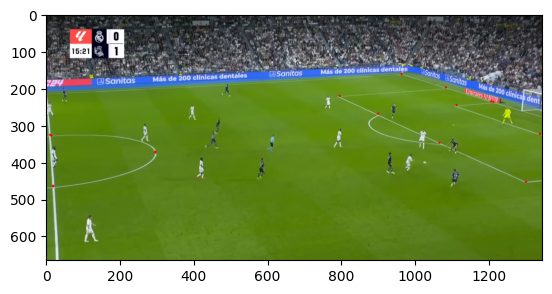

In [20]:

points = img.copy()

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points = cv2.circle(points, center, 3, (255, 0, 0), -1)

plt.imshow(points)